# Notebook 06: Modeling & Evaluation

In this notebook, we demonstrate how to train and evaluate **baseline models** for air quality classification using the **pseudo-labeled dataset** generated in Notebook 05.  

We train models on the **1-hour aggregated data** with pseudo-labels from KMeans and DBSCAN.  
Performance is reported via **Accuracy** and **Macro-F1**, and results are compared to the annotated AQI categories discussed in the research paper.  

> **Note:**  
> This notebook is provided as a demonstration of the modeling workflow.  
> In the research paper, training was performed on the **full dataset**, and the figures were refined for clarity.

> **Disclaimer:**  
> The code and visualizations in this notebook are provided as an illustrative example of our workflow.  
> For simplicity, we use a subset of the dataset and minimal preprocessing here.  
> In the research paper, we used the **full dataset** and refined the plots (e.g., styling, formatting, layout) to better communicate the results.  
> Thus, the figures shown in the paper may look different or "prettier," but they were derived from the same pipeline presented here.

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load the Pseudo-Labeled Dataset

We use the file generated in Notebook 05:  
`pseudo_labels_dbscan_kmeans_1hour.csv`  

In [2]:
df = pd.read_csv("../data/aggregated/pseudo_labels_dbscan_kmeans_1hour.csv")
print(df.shape)
df.head()

(1925, 8)


,timestamp,node_id,hih6130,hih6130.1,htu21d,htu21d.1,kmeans_label,dbscan_label
0,NaN,NaN,humidity,temperature,humidity,temperature,NaN,NaN
1,2020-01-12 00:00:00,001e0610ee36,100.0,125.01,118.99,128.86,1.0,0.0
2,2020-01-12 00:00:00,001e0610ee43,29.881428571428568,23.9075,87.32321428571429,0.765,2.0,0.0
3,2020-01-12 00:00:00,001e0610f05c,65.01,17.57,118.99,0.0032857142857142,0.0,0.0
4,2020-01-12 00:00:00,001e06113107,67.20401459854016,5.088832116788321,95.23153284671533,0.0914598540145985,0.0,0.0


## 2. Prepare Features and Labels

- Features: all numeric sensor-parameter values.  
- Labels: `kmeans_label` (primary) and optionally `dbscan_label`.  

We drop rows where DBSCAN assigned `-1` (outliers).

In [5]:
# --- Clean labels before splitting ---
# Drop rows where kmeans_label is NaN
df_clean = df.dropna(subset=["kmeans_label"]).copy()

# Extract features and labels
X = df_clean[feature_cols].values
y_kmeans = df_clean["kmeans_label"].astype(int).values   # ensure labels are integers

print("Samples after cleaning:", X.shape, y_kmeans.shape)
print("Unique labels:", np.unique(y_kmeans))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_kmeans, test_size=0.3, random_state=42, stratify=y_kmeans
)


Samples after cleaning: (1924, 4) (1924,)
Unique labels: [0 1 2 3 4]


## 3. Train/Test Split
We split data into **70% training** and **30% testing**.  

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_kmeans, test_size=0.3, random_state=42, stratify=y_kmeans)

## 4. Baseline Models

We train two models for demonstration:  

- **Logistic Regression** (simple linear baseline).  
- **Random Forest Classifier** (nonlinear ensemble).  

In [7]:
# Logistic Regression
logreg = LogisticRegression(max_iter=500, multi_class="multinomial")
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

/Users/razalimirza/Desktop/AoT-Node-Similarity-Analysis/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## 5. Evaluation Metrics

We evaluate models with:  
- **Accuracy**  
- **Macro-F1**  
- **Confusion Matrix**  

Logistic Regression - Accuracy: 1.000, Macro-F1: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       170
           1       1.00      1.00      1.00       239
           2       1.00      1.00      1.00       101
           3       1.00      1.00      1.00        43
           4       1.00      1.00      1.00        25

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



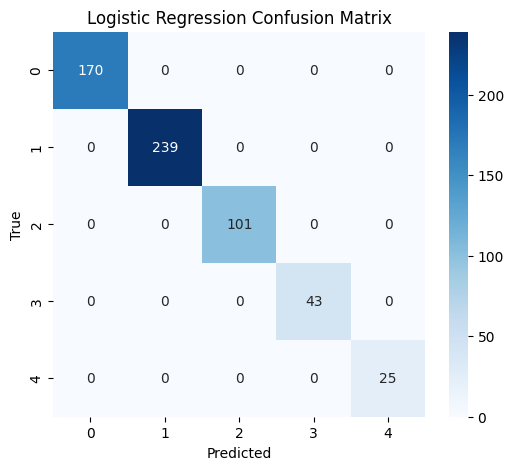

Random Forest - Accuracy: 0.998, Macro-F1: 0.995
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       170
           1       1.00      1.00      1.00       239
           2       1.00      1.00      1.00       101
           3       1.00      1.00      1.00        43
           4       1.00      0.96      0.98        25

    accuracy                           1.00       578
   macro avg       1.00      0.99      1.00       578
weighted avg       1.00      1.00      1.00       578



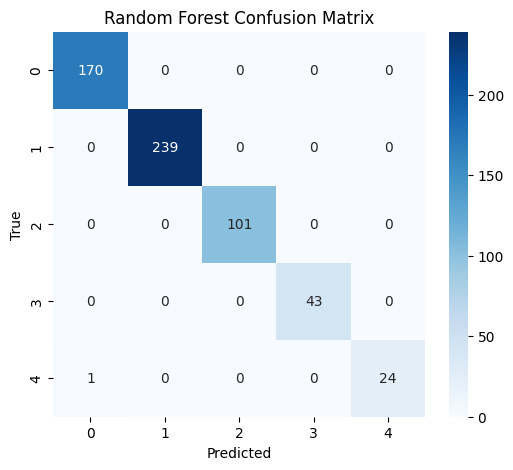

In [8]:
def evaluate(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    print(f"{model_name} - Accuracy: {acc:.3f}, Macro-F1: {f1:.3f}")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Evaluate both models
evaluate(y_test, y_pred_log, "Logistic Regression")
evaluate(y_test, y_pred_rf, "Random Forest")

## 6. Notes

- **Pseudo-labels are not ground truth**: They provide an unsupervised grouping aligned with AQI categories but should not be interpreted as official air quality annotations.  
- Logistic Regression offers a lightweight baseline, while Random Forest captures more complex feature interactions.  
- Results shown here are **illustrative**. For the research paper, training was performed on the **full dataset**, and figures were refined for readability.  